# RLLBC Bonus Point Assignment II Part A
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2021-06-24</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

## Question A2 - Policy Gradients

In [31]:
# Imports
import gym
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

Note: The next cell is optional, as this will _not_ run on the JupterHub. To render the CartPole environemnt, you need to set up your Jupyter environment locally (see assignment PDF). Rendering is not required for this assignment, but the visualization may help you to understand what your policy is atually learning.

In [32]:
# Take a look at the environment (Does not run on the JupyterHub)
env = gym.make('CartPole-v1')

for _ in range(10):
    state, done = env.reset(), False
    while not done:
        action = env.action_space.sample()  # Random action
        state, _, done, _ = env.step(action)

        env.render()

env.close()

### a) Defining the Policy

In [33]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # ********************
        # TODO Create layers
        self.input = nn.Linear(4,128)
        self.hidden1 = nn.ReLU()
        self.hidden2 = nn.Linear(128,2)
        self.output = nn.Softmax()
        # ********************

    def forward(self, x):
        # ********************
        # TODO Implement forward pass
      
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.output(x)
        # ********************
        return x

In [34]:
# Test code
_test_output = Policy()(torch.tensor([[1.0, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
np.testing.assert_almost_equal(_test_output.detach().numpy().sum(), 1, err_msg="Output is not a probability distribution.")
"ok"

C:\Users\Sanjay\AppData\Local\Temp\ipykernel_4800\3049123097.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


'ok'

### b) Action Sampling

In [35]:
def sample_action(probs):
    """Sample one action from the action distribution of this state.
    
    Args:
        probs: action probabilities

    Returns:
        action: The sampled action
        log_prob: Logarithm of the probability for sampling that action
    """
    # TODO Implement action sampling
    action_distribution = torch.distributions.Categorical(probs)
    action = action_distribution.sample()
    log_prob = action_distribution.log_prob(action)
    
    return action, log_prob


In [36]:
# Test code
_test_action, _test_log_prob = sample_action(torch.tensor([1, 2, 3, 4]))
assert _test_action in [0, 1, 2, 3], f"Invalid action {_test_action}"
np.testing.assert_approx_equal(_test_log_prob, np.log((_test_action + 1) / 10))
"ok"

'ok'

### c) Return Estimation

In [37]:
def estimate_return(rewards, gamma=0.99):
    """Estimate return based of observed rewards
    
    Args:
        rewards: Series of observed rewards
        gamma: discount factor
    """
    # TODO Implement return estimation
    
    returns = [0]*(len(rewards))
    returns[-1] = rewards[-1]
    for i in range(len(rewards)-1):
        returns[-2-i] = rewards[-2-i] + gamma*returns[-1-i]
        
    # normalization
    mean = np.mean(returns)
    std = np.std(returns)
    returns = (returns - mean) / std

    return returns

In [38]:
# Test code
np.testing.assert_array_almost_equal(
    estimate_return(np.ones(10), gamma=0.99),
    [1.54572815, 1.21139962, 0.87369404, 0.53257729, 0.18801491, -0.16002789, -0.51158628, -0.86669576, -1.22539221, -1.58771185]
)
"ok"

'ok'

### d) Training Loop

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Temp\ipykernel_4800\3049123097.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)
Mean training reward 495.89: 100%|██████████| 1000/1000 [12:28<00:00,  1.34it/s]


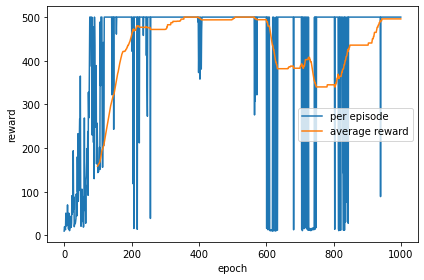

In [39]:
env = gym.make('CartPole-v1')
policy = Policy()

# Hyperparams
episodes = 1000
gamma = 0.99
learn_rate = 1e-2
optimizer = torch.optim.Adam(policy.parameters(), lr=learn_rate)

total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        # Run one episode
        log_probs = []
        rewards = []
        state, done = env.reset(), False
        while not done:
            # Take a step
            # ********************
            # TODO Sample action for current state

            probs = policy.forward(torch.tensor(state))
            action, log_prob = sample_action(probs)

            # ********************
            state, reward, done, _ = env.step(action.numpy())

            # Bookkeeping
            log_probs.append(log_prob)
            rewards.append(reward)

        total_rewards.append(sum(rewards))

        # ********************
        # TODO Compute loss

        estimated_return = estimate_return(rewards)
        policy_loss = 0
        for i in range(len(log_probs)):
            policy_loss -= log_probs[i] * estimated_return[i]

        # ********************

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")

# Save model
with open("solution/a2d.pt", "wb") as f:
    torch.save(policy, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/a2d.png")

In [40]:
# Test code
policy.eval()  # Switch to evaluation mode


def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps


_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Temp\ipykernel_4800\3049123097.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)
Validating: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


'ok (Average reward 500.00)'

In [41]:
# Take a look at the learned policy (this will not run on the JupyterHub)
greedy = True

policy.eval()  # Switch to evaluation mode
state, done = env.reset(), False
while not done:
    probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
    if greedy:
        action = np.argmax(probs.detach().numpy())  # Chose optimal action
    else:
        action = sample_action(probs)[0]  # Sample from action distribution
    state, _, done, _ = env.step(action)
    env.render()

env.close()

C:\Users\Sanjay\AppData\Local\Temp\ipykernel_4800\3049123097.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)
